# Прогноз погоды в Москве: LSTM и Transformer

- Задача: спрогнозировать среднесуточную температуру в Москве (станция 27612) за счёт LSTM и Transformer.
- Данные: http://www.pogodaiklimat.ru/weather.php?id=27612 (мониторинг `monitor.php`).
- Библиотеки: numpy, pandas, matplotlib, scikit-learn, torch.
- Шаги: загрузка и очистка → baseline → LSTM → Transformer → сравнение → прогноз на дату защиты.


In [1]:
# Импорты и базовые настройки
from pathlib import Path
import datetime as dt
import math
import pickle
from typing import Dict, Tuple, List

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt  # docs: https://matplotlib.org/stable/api/pyplot_api.html
from sklearn.preprocessing import StandardScaler  # docs: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
from sklearn.metrics import mean_absolute_error, mean_squared_error  # docs: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset  # docs: https://pytorch.org/docs/stable/data.html

# Пути и общие параметры
BASE_DIR = Path('.')
DATA_DIR = BASE_DIR / 'data'
DATA_DIR.mkdir(exist_ok=True)
RAW_PATH = DATA_DIR / 'weather_raw.csv'
STATION_ID = 27612
MONITOR_URL = 'http://www.pogodaiklimat.ru/monitor.php'


In [2]:
# Функции загрузки и предобработки данных

def fetch_month(year: int, month: int) -> pd.DataFrame:
    """Скачивает один месяц с pogodaiklimat.ru и возвращает датафрейм с date/temp."""
    url = f"{MONITOR_URL}?id={STATION_ID}&month={month}&year={year}"
    tables = pd.read_html(url)  # docs: https://pandas.pydata.org/docs/reference/api/pandas.read_html.html
    if not tables:
        return pd.DataFrame(columns=['date', 'temp'])
    table = tables[0]
    if len(table) < 3:
        return pd.DataFrame(columns=['date', 'temp'])
    header = table.iloc[1].tolist()
    data = table.iloc[2:].copy()
    data.columns = header
    rename_map = {'Средняя': 'temp'}
    optional_candidates = {
        'tmin': ['Минимальная', 'Мин.', 'Мин'],
        'tmax': ['Максимальная', 'Макс.', 'Макс'],
        'pressure': ['Давление', 'Давл.', 'давление'],
    }
    for target, candidates in optional_candidates.items():
        for cand in candidates:
            if cand in data.columns:
                rename_map[cand] = target
                break
    data = data.rename(columns=rename_map)
    if 'temp' not in data.columns or 'Дата' not in data.columns:
        return pd.DataFrame(columns=['date', 'temp'])
    numeric_cols = [col for col in ['temp', 'tmin', 'tmax', 'pressure'] if col in data.columns]
    data = data[['Дата', *numeric_cols]].copy()
    data['date'] = pd.to_datetime(
        {'year': year, 'month': month, 'day': pd.to_numeric(data['Дата'], errors='coerce')},
        errors='coerce',
    )
    for col in numeric_cols:
        data[col] = pd.to_numeric(data[col].astype(str).str.replace(',', '.'), errors='coerce')
    data = data.dropna(subset=['date', 'temp'])
    keep_cols = ['date', *numeric_cols]
    return data[keep_cols]


def download_weather_history(years: int = 10, save_path: Path = RAW_PATH) -> pd.DataFrame:
    """Скачивает историю за указанное число лет и сохраняет в CSV."""
    frames = []
    today = dt.date.today()
    start_year = today.year - years + 1
    for year in range(start_year, today.year + 1):
        for month in range(1, 13):
            if year == today.year and month > today.month:
                break
            try:
                month_df = fetch_month(year, month)
                if not month_df.empty:
                    frames.append(month_df)
            except Exception as err:
                print(f"skip {month}.{year}: {err}")
    if not frames:
        raise RuntimeError('Не удалось загрузить данные погоды.')
    df = pd.concat(frames).sort_values('date').reset_index(drop=True)
    df.to_csv(save_path, index=False)
    return df


def load_raw_dataframe() -> pd.DataFrame:
    """Загружает сырые данные, при отсутствии скачивает их."""
    if RAW_PATH.exists():
        return pd.read_csv(RAW_PATH, parse_dates=['date'])
    return download_weather_history()


def clean_and_resample(df: pd.DataFrame) -> pd.DataFrame:
    """Чистит пропуски, ресемплирует до дня и добавляет сезонные признаки."""
    df = df.copy()
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values('date')
    daily = df.set_index('date').resample('D').mean()
    daily = daily.interpolate(method='time', limit_direction='both')  # docs: https://pandas.pydata.org/docs/reference/api/pandas.Series.interpolate.html
    daily = daily.reset_index()
    daily['day_of_year'] = daily['date'].dt.dayofyear
    daily['sin_doy'] = np.sin(2 * np.pi * daily['day_of_year'] / 365)
    daily['cos_doy'] = np.cos(2 * np.pi * daily['day_of_year'] / 365)
    feature_cols = ['temp', 'sin_doy', 'cos_doy'] + [col for col in ['tmin', 'tmax', 'pressure'] if col in daily.columns]
    feature_df = daily[feature_cols].copy()
    feature_df.index = daily['date']
    return feature_df


def create_windows(series: np.ndarray, window_size: int, horizon: int) -> Tuple[np.ndarray, np.ndarray]:
    """Формирует окна временного ряда X и цели y."""
    X, y = [], []
    for idx in range(len(series) - window_size - horizon + 1):
        X.append(series[idx: idx + window_size, :])
        y.append(series[idx + window_size: idx + window_size + horizon, 0])
    X_arr = np.array(X)
    y_arr = np.array(y).reshape(-1, horizon)
    return X_arr, y_arr


def split_data(X: np.ndarray, y: np.ndarray, test_size: float, val_size: float, indices: np.ndarray | None = None) -> Dict[str, np.ndarray]:
    """Делит данные на train/val/test по долям и синхронно делит индексы."""
    total = len(X)
    test_count = int(total * test_size)
    val_count = int(total * val_size)
    train_count = total - test_count - val_count
    data = {
        'X_train': X[:train_count],
        'y_train': y[:train_count],
        'X_val': X[train_count: train_count + val_count],
        'y_val': y[train_count: train_count + val_count],
        'X_test': X[train_count + val_count:],
        'y_test': y[train_count + val_count:],
    }
    if indices is not None:
        data['idx_train'] = indices[:train_count]
        data['idx_val'] = indices[train_count: train_count + val_count]
        data['idx_test'] = indices[train_count + val_count:]
    return data


def create_dataloader(X: np.ndarray, y: np.ndarray, batch_size: int, shuffle: bool = True) -> DataLoader:
    """Собирает DataLoader для torch."""
    X_t = torch.tensor(X, dtype=torch.float32)
    y_t = torch.tensor(y, dtype=torch.float32)
    dataset = TensorDataset(X_t, y_t)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)


def prepare_datasets(window_size: int = 120, horizon: int = 7, test_size: float = 0.2, val_size: float = 0.1, batch_size: int = 32, feature_cols: List[str] | None = None, series: pd.DataFrame | None = None):
    """Полный цикл: загрузка, очистка, нормализация, окна и даталоадеры."""
    raw_df = load_raw_dataframe() if series is None else None
    series_local = series if series is not None else clean_and_resample(raw_df)
    feature_cols = feature_cols or ['temp', 'sin_doy', 'cos_doy']
    scaler = StandardScaler()
    scaled = scaler.fit_transform(series_local[feature_cols])
    indices = np.arange(len(series_local) - window_size - horizon + 1)
    X, y = create_windows(scaled, window_size, horizon)
    splits = split_data(X, y, test_size=test_size, val_size=val_size, indices=indices)
    loaders = {
        'train_loader': create_dataloader(splits['X_train'], splits['y_train'], batch_size=batch_size, shuffle=True),
        'val_loader': create_dataloader(splits['X_val'], splits['y_val'], batch_size=batch_size, shuffle=False),
    }
    result = {**splits, **loaders, 'scaler': scaler, 'series': series_local, 'scaled_series': scaled, 'feature_cols': feature_cols}
    return result


In [3]:
# Baseline: прогноз равен вчерашнему значению

def baseline_predict(X: np.ndarray, horizon: int) -> np.ndarray:
    """Повторяет последнее наблюдение температуры на горизонт."""
    if X.ndim != 3:
        raise ValueError('Ожидается массив формы [n_samples, window_size, features].')
    last_temp = X[:, -1, 0]
    return np.repeat(last_temp[:, None], horizon, axis=1)


def moving_average_predict(X: np.ndarray, horizon: int, window: int = 7) -> np.ndarray:
    """Прогноз средним за последние window дней по температуре."""
    if X.ndim != 3:
        raise ValueError('Ожидается массив формы [n_samples, window_size, features].')
    tail = X[:, -window:, 0]
    mean_vals = tail.mean(axis=1)
    return np.repeat(mean_vals[:, None], horizon, axis=1)


def seasonal_naive_predict(series_scaled: np.ndarray, sample_indices: np.ndarray, window_size: int, horizon: int) -> np.ndarray:
    """Температура в те же даты год назад, fallback на последнее наблюдение если истории < 365."""
    temps = series_scaled[:, 0]
    preds = []
    for start in sample_indices:
        window_preds = []
        for step in range(horizon):
            target_idx = start + window_size + step
            ref_idx = target_idx - 365
            if ref_idx >= 0:
                window_preds.append(temps[ref_idx])
            else:
                window_preds.append(temps[target_idx - 1])
        preds.append(window_preds)
    return np.array(preds)


In [4]:
# LSTM модель и обучение

class LSTMForecaster(nn.Module):
    """Stacked LSTM для мультишагового прогноза."""
    def __init__(self, input_size: int = 3, hidden_size: int = 128, num_layers: int = 2, dropout: float = 0.2, horizon: int = 7):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, horizon)
    def forward(self, x):
        output, _ = self.lstm(x)
        last_hidden = output[:, -1, :]
        return self.fc(last_hidden)


def train_lstm(train_loader, val_loader, device: str = 'cpu', epochs: int = 20, lr: float = 1e-3, hidden_size: int = 128, horizon: int = 7):
    """Обучает LSTM и возвращает историю потерь."""
    model = LSTMForecaster(hidden_size=hidden_size, horizon=horizon).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)  # docs: https://pytorch.org/docs/stable/generated/torch.optim.Adam.html
    history = []
    best_state = None
    best_val = float('inf')
    best_epoch = 0
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            preds = model(X_batch)
            loss = criterion(preds, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= max(1, len(train_loader))
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                preds = model(X_batch)
                loss = criterion(preds, y_batch)
                val_loss += loss.item()
        val_loss /= max(1, len(val_loader))
        if val_loss < best_val:
            best_val = val_loss
            best_epoch = epoch + 1
            best_state = {k: v.detach().clone() for k, v in model.state_dict().items()}
        history.append({'epoch': epoch + 1, 'train_loss': train_loss, 'val_loss': val_loss})
        print(f"[LSTM] epoch {epoch+1}: train={train_loss:.4f} val={val_loss:.4f}")
    if best_state is not None:
        model.load_state_dict(best_state)
        print(f"[LSTM] best epoch {best_epoch} restored (val={best_val:.4f})")
    return model, history


In [5]:
# Transformer модель и обучение

class PositionalEncoding(nn.Module):
    """Синусоидальное позиционное кодирование."""
    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 500):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        positions = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, d_model)
        pe[:, 0::2] = torch.sin(positions * div_term)
        pe[:, 1::2] = torch.cos(positions * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))
    def forward(self, x):
        x = x + self.pe[:, : x.size(1), :]
        return self.dropout(x)


class TransformerForecaster(nn.Module):
    """Encoder-only Transformer: позиционное кодирование -> encoder -> линейный выход."""
    def __init__(self, input_size: int = 3, d_model: int = 128, nhead: int = 8, num_layers: int = 4, dim_feedforward: int = 256, horizon: int = 7):
        super().__init__()
        self.input_proj = nn.Linear(input_size, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, batch_first=True)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)  # docs: https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoder.html
        self.pos_encoding = PositionalEncoding(d_model)
        self.fc = nn.Linear(d_model, horizon)
    def forward(self, x):
        x = self.input_proj(x)
        x = self.pos_encoding(x)
        seq_len = x.size(1)
        mask = torch.triu(torch.ones(seq_len, seq_len), diagonal=1).bool().to(x.device)
        encoded = self.encoder(x, mask=mask)
        last = encoded[:, -1, :]
        return self.fc(last)


def train_transformer(train_loader, val_loader, device: str = 'cpu', epochs: int = 20, lr: float = 5e-4, d_model: int = 128, nhead: int = 8, num_layers: int = 4, dim_feedforward: int = 256, horizon: int = 7, patience: int = 5, min_delta: float = 1e-4, input_size: int = 3):
    """Обучает Transformer и возвращает историю потерь."""
    model = TransformerForecaster(input_size=input_size, d_model=d_model, nhead=nhead, num_layers=num_layers, dim_feedforward=dim_feedforward, horizon=horizon).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)
    history = []
    best_state = None
    best_val = float('inf')
    best_epoch = 0
    epochs_no_improve = 0
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            preds = model(X_batch)
            loss = criterion(preds, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= max(1, len(train_loader))
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                preds = model(X_batch)
                loss = criterion(preds, y_batch)
                val_loss += loss.item()
        val_loss /= max(1, len(val_loader))
        scheduler.step(val_loss)
        if val_loss < best_val - min_delta:
            best_val = val_loss
            best_epoch = epoch + 1
            best_state = {k: v.detach().clone() for k, v in model.state_dict().items()}
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
        history.append({'epoch': epoch + 1, 'train_loss': train_loss, 'val_loss': val_loss, 'lr': optimizer.param_groups[0]['lr']})
        print(f"[Transformer] epoch {epoch+1}: train={train_loss:.4f} val={val_loss:.4f} lr={optimizer.param_groups[0]['lr']:.1e}")
        if epochs_no_improve >= patience:
            print(f"[Transformer] early stop at epoch {epoch+1} (best={best_epoch})")
            break
    if best_state is not None:
        model.load_state_dict(best_state)
        print(f"[Transformer] best epoch {best_epoch} restored (val={best_val:.4f})")
    return model, history


In [6]:
# Загрузка данных, подготовка и baseline

WINDOW_LSTM = 120
WINDOW_TRANSFORMER = 365  # Transformer берет больше контекста, чтобы ловить годовую сезонность
WINDOW = WINDOW_LSTM
HORIZON = 7
BATCH = 32
TEST_SIZE = 0.2
VAL_SIZE = 0.1
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f'Используем device={DEVICE}')

skip_download = False
if skip_download and RAW_PATH.exists():
    raw_df = pd.read_csv(RAW_PATH, parse_dates=['date'])
else:
    raw_df = download_weather_history()

series = clean_and_resample(raw_df)
base_features = ['temp', 'sin_doy', 'cos_doy']
extra_features = [col for col in ['tmin', 'tmax', 'pressure'] if col in series.columns]
transformer_features = base_features + extra_features
print(f"Фичи для Transformer: {transformer_features}")

def build_dataset(series_df, feature_cols, window_size):
    return prepare_datasets(window_size=window_size, horizon=HORIZON, test_size=TEST_SIZE, val_size=VAL_SIZE, batch_size=BATCH, feature_cols=feature_cols, series=series_df)

lstm_data = build_dataset(series, base_features, WINDOW_LSTM)
train_loader = lstm_data['train_loader']
val_loader = lstm_data['val_loader']
splits = {k: lstm_data[k] for k in ['X_train', 'y_train', 'X_val', 'y_val', 'X_test', 'y_test', 'idx_test']}
scaler = lstm_data['scaler']

transformer_data = build_dataset(series, transformer_features, WINDOW_TRANSFORMER)
transformer_train_loader = transformer_data['train_loader']
transformer_val_loader = transformer_data['val_loader']
transformer_scaler = transformer_data['scaler']


Используем device=cpu
Фичи для Transformer: ['temp', 'sin_doy', 'cos_doy']


[LSTM] epoch 1: train=0.3008 val=0.2102
[LSTM] epoch 2: train=0.1683 val=0.1957
[LSTM] epoch 3: train=0.1622 val=0.1965
[LSTM] epoch 4: train=0.1582 val=0.1790
[LSTM] epoch 5: train=0.1514 val=0.1723
[LSTM] epoch 6: train=0.1480 val=0.1699
[LSTM] epoch 7: train=0.1482 val=0.1628
[LSTM] epoch 8: train=0.1412 val=0.1655
[LSTM] epoch 9: train=0.1406 val=0.1562
[LSTM] epoch 10: train=0.1408 val=0.1709
[LSTM] epoch 11: train=0.1419 val=0.1631
[LSTM] epoch 12: train=0.1376 val=0.1618
[LSTM] epoch 13: train=0.1377 val=0.1566
[LSTM] epoch 14: train=0.1386 val=0.1575
[LSTM] epoch 15: train=0.1364 val=0.1609
[LSTM] epoch 16: train=0.1384 val=0.1605
[LSTM] epoch 17: train=0.1348 val=0.1595
[LSTM] epoch 18: train=0.1340 val=0.1648
[LSTM] epoch 19: train=0.1353 val=0.1652
[LSTM] epoch 20: train=0.1347 val=0.1557
[LSTM] epoch 21: train=0.1318 val=0.1616
[LSTM] epoch 22: train=0.1308 val=0.1542
[LSTM] epoch 23: train=0.1339 val=0.1610
[LSTM] epoch 24: train=0.1332 val=0.1553
[LSTM] epoch 25: train=0.

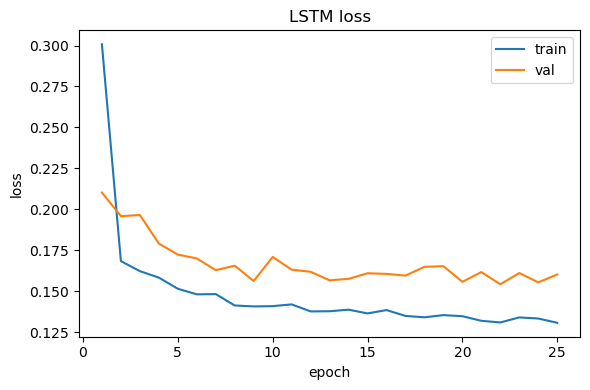

In [7]:
# Обучение LSTM
lstm_model, lstm_history = train_lstm(train_loader, val_loader, device=DEVICE, epochs=25, horizon=HORIZON)
best_lstm = min(lstm_history, key=lambda h: h['val_loss'])
best_lstm_epoch, best_lstm_val = best_lstm['epoch'], best_lstm['val_loss']
print(f"Лучший LSTM по val: epoch={best_lstm_epoch}, loss={best_lstm_val:.4f}")

# Сохраняем веса и скейлер
with open(DATA_DIR / 'scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
torch.save(lstm_model.state_dict(), DATA_DIR / 'lstm.pt')  # docs: https://pytorch.org/docs/stable/generated/torch.save.html

# График потерь
plt.figure(figsize=(6,4))
plt.plot([h['epoch'] for h in lstm_history], [h['train_loss'] for h in lstm_history], label='train')
plt.plot([h['epoch'] for h in lstm_history], [h['val_loss'] for h in lstm_history], label='val')
plt.xlabel('epoch'); plt.ylabel('loss'); plt.title('LSTM loss'); plt.legend(); plt.tight_layout()
plt.show()


[Transformer] epoch 1: train=0.2553 val=0.1982 lr=5.0e-04
[Transformer] epoch 2: train=0.1679 val=0.1977 lr=5.0e-04
[Transformer] epoch 3: train=0.1641 val=0.1793 lr=5.0e-04
[Transformer] epoch 4: train=0.1614 val=0.1784 lr=5.0e-04
[Transformer] epoch 5: train=0.1592 val=0.1809 lr=5.0e-04
[Transformer] epoch 6: train=0.1555 val=0.1851 lr=5.0e-04
[Transformer] epoch 7: train=0.1511 val=0.1744 lr=5.0e-04
[Transformer] epoch 8: train=0.1502 val=0.1768 lr=5.0e-04
[Transformer] epoch 9: train=0.1485 val=0.1767 lr=5.0e-04
[Transformer] epoch 10: train=0.1457 val=0.1837 lr=2.5e-04
[Transformer] epoch 11: train=0.1412 val=0.1821 lr=2.5e-04
[Transformer] epoch 12: train=0.1385 val=0.1748 lr=2.5e-04
[Transformer] epoch 13: train=0.1349 val=0.1690 lr=2.5e-04
[Transformer] epoch 14: train=0.1365 val=0.1826 lr=2.5e-04
[Transformer] epoch 15: train=0.1316 val=0.1943 lr=2.5e-04
[Transformer] epoch 16: train=0.1299 val=0.1880 lr=1.3e-04
[Transformer] epoch 17: train=0.1244 val=0.1909 lr=1.3e-04
[Trans

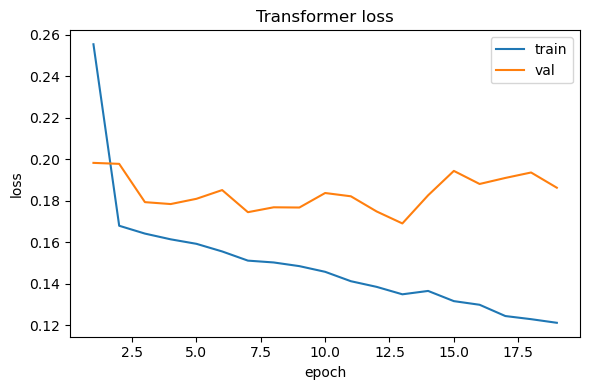

In [9]:
# Обучение Transformer
transformer_input_size = len(transformer_features)
transformer_d_model = 96 + 16 * max(0, transformer_input_size - 3)  # d_model кратен nhead и растет вместе с числом фич
transformer_model, transformer_history = train_transformer(transformer_train_loader, transformer_val_loader, device=DEVICE, epochs=60, lr=5e-4, horizon=HORIZON, patience=6, input_size=transformer_input_size, d_model=transformer_d_model)
best_transf = min(transformer_history, key=lambda h: h['val_loss'])
best_transformer_epoch, best_transformer_val = best_transf['epoch'], best_transf['val_loss']
print(f"Лучший Transformer по val: epoch={best_transformer_epoch}, loss={best_transformer_val:.4f}")

torch.save(transformer_model.state_dict(), DATA_DIR / 'transformer.pt')

plt.figure(figsize=(6,4))
plt.plot([h['epoch'] for h in transformer_history], [h['train_loss'] for h in transformer_history], label='train')
plt.plot([h['epoch'] for h in transformer_history], [h['val_loss'] for h in transformer_history], label='val')
plt.xlabel('epoch'); plt.ylabel('loss'); plt.title('Transformer loss'); plt.legend(); plt.tight_layout()
plt.show()


Naive last-value (окно 365) MAE=3.122 RMSE=4.137
Moving avg 7d (окно 365) MAE=3.373 RMSE=4.379
Seasonal naive MAE=4.431 RMSE=5.723
LSTM MAE=2.849 RMSE=3.637 (best epoch 22)
Transformer MAE=3.005 RMSE=3.813 (best epoch 13)


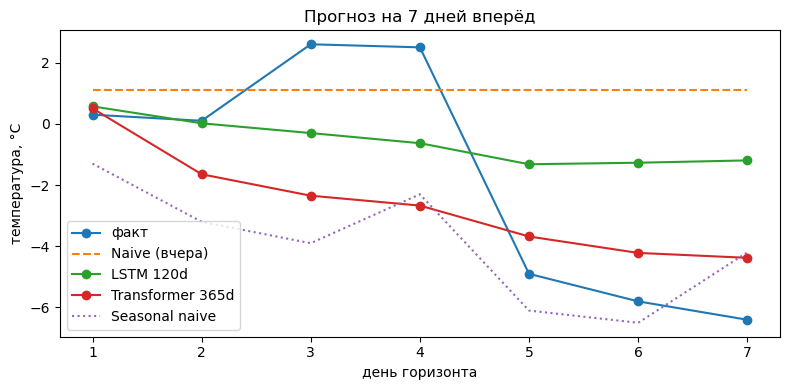

In [14]:
# Оценка моделей и визуализация

def inverse_temp(values: np.ndarray, scaler=None, feature_cols=None):
    if scaler is None:
        return values
    arr = np.array(values)
    feature_cols = feature_cols or ['temp', 'sin_doy', 'cos_doy']
    temp_idx = feature_cols.index('temp')
    dummy = np.zeros((arr.shape[0] * arr.shape[1], len(feature_cols)))
    dummy[:, temp_idx] = arr.reshape(-1)
    restored = scaler.inverse_transform(dummy)[:, temp_idx]
    return restored.reshape(arr.shape)

def evaluate_model(model, X_test, y_test, scaler=None, device: str = 'cpu', use_baseline: str | None = None, series_scaled=None, sample_indices=None, window_size: int | None = None, horizon: int = HORIZON, feature_cols=None):
    """MAE и RMSE для baseline или torch-модели."""
    feature_cols = feature_cols or ['temp', 'sin_doy', 'cos_doy']
    if use_baseline == 'naive':
        preds_scaled = baseline_predict(X_test, horizon)
    elif use_baseline == 'moving_avg':
        preds_scaled = moving_average_predict(X_test, horizon)
    elif use_baseline == 'seasonal':
        if series_scaled is None or sample_indices is None:
            raise ValueError('Для seasonal naive нужны series_scaled и sample_indices.')
        preds_scaled = seasonal_naive_predict(series_scaled, sample_indices, window_size or len(X_test[0]), horizon)
    else:
        model.eval()
        with torch.no_grad():
            inputs = torch.tensor(X_test, dtype=torch.float32).to(device)
            preds_scaled = model(inputs).cpu().numpy()
    y_true_scaled = np.array(y_test)
    y_true = inverse_temp(y_true_scaled, scaler, feature_cols)
    preds = inverse_temp(preds_scaled, scaler, feature_cols)
    mae = mean_absolute_error(y_true.reshape(-1), preds.reshape(-1))
    rmse = mean_squared_error(y_true.reshape(-1), preds.reshape(-1)) ** 0.5
    return {'mae': mae, 'rmse': rmse, 'y_true': y_true, 'preds': preds}

def rolling_evaluation(train_years=[2016, 2017, 2018, 2019, 2020], test_year: int = 2021, window_size: int = WINDOW, horizon: int = HORIZON, train_models: bool = False, epochs: int = 5, device: str = DEVICE):
    """Оценка на скользящих окнах по годам, возвращает средние MAE/RMSE."""
    raw_df = load_raw_dataframe()
    series_full = clean_and_resample(raw_df)
    dates = series_full.index.to_numpy()
    results = {'naive': [], 'moving_avg': [], 'seasonal': [], 'lstm': [], 'transformer': []}
    for train_year in train_years:
        scaler_local = StandardScaler()
        scaler_local.fit(series_full.loc[series_full.index.year <= train_year, ['temp', 'sin_doy', 'cos_doy']])
        scaled_full = scaler_local.transform(series_full[['temp', 'sin_doy', 'cos_doy']])
        sample_indices = np.arange(len(series_full) - window_size - horizon + 1)
        target_starts = pd.DatetimeIndex(dates[window_size: window_size + len(sample_indices)])
        X_all, y_all = create_windows(scaled_full, window_size, horizon)
        test_mask = target_starts.year == test_year
        train_mask = target_starts.year <= train_year
        if not test_mask.any() or len(X_all) == 0:
            continue
        X_train, y_train = X_all[train_mask], y_all[train_mask]
        X_test_run, y_test_run = X_all[test_mask], y_all[test_mask]
        idx_test_run = sample_indices[test_mask]
        results['naive'].append(evaluate_model(None, X_test_run, y_test_run, scaler=scaler_local, device=device, use_baseline='naive', series_scaled=scaled_full, sample_indices=idx_test_run, window_size=window_size, horizon=horizon))
        results['moving_avg'].append(evaluate_model(None, X_test_run, y_test_run, scaler=scaler_local, device=device, use_baseline='moving_avg', series_scaled=scaled_full, sample_indices=idx_test_run, window_size=window_size, horizon=horizon))
        results['seasonal'].append(evaluate_model(None, X_test_run, y_test_run, scaler=scaler_local, device=device, use_baseline='seasonal', series_scaled=scaled_full, sample_indices=idx_test_run, window_size=window_size, horizon=horizon))
        if train_models and len(X_train) > 0:
            split = max(1, int(len(X_train) * 0.8))
            train_loader = create_dataloader(X_train[:split], y_train[:split], batch_size=64, shuffle=True)
            val_loader = create_dataloader(X_train[split:], y_train[split:], batch_size=64, shuffle=False) if split < len(X_train) else create_dataloader(X_train[:1], y_train[:1], batch_size=64, shuffle=False)
            lstm_local, _ = train_lstm(train_loader, val_loader, device=device, epochs=epochs, horizon=horizon)
            transformer_local, _ = train_transformer(train_loader, val_loader, device=device, epochs=epochs, horizon=horizon)
            results['lstm'].append(evaluate_model(lstm_local, X_test_run, y_test_run, scaler=scaler_local, device=device, horizon=horizon))
            results['transformer'].append(evaluate_model(transformer_local, X_test_run, y_test_run, scaler=scaler_local, device=device, horizon=horizon))
    summary = {}
    for name, metrics in results.items():
        if metrics:
            summary[name] = {
                'mae': float(np.mean([m['mae'] for m in metrics])),
                'rmse': float(np.mean([m['rmse'] for m in metrics])),
            }
    return summary

offset_idx = WINDOW_TRANSFORMER - WINDOW_LSTM
aligned_indices = transformer_data['idx_test'] + offset_idx
lstm_series_scaled = lstm_data['scaled_series']
aligned_X_lstm = np.array([lstm_series_scaled[idx: idx + WINDOW_LSTM] for idx in aligned_indices])
aligned_y_lstm = np.array([lstm_series_scaled[idx + WINDOW_LSTM: idx + WINDOW_LSTM + HORIZON, 0] for idx in aligned_indices])

naive_metrics = evaluate_model(None, transformer_data['X_test'], transformer_data['y_test'], scaler=transformer_scaler, device=DEVICE, use_baseline='naive', series_scaled=transformer_data['scaled_series'], sample_indices=transformer_data['idx_test'], window_size=WINDOW_TRANSFORMER, horizon=HORIZON, feature_cols=transformer_features)
moving_metrics = evaluate_model(None, transformer_data['X_test'], transformer_data['y_test'], scaler=transformer_scaler, device=DEVICE, use_baseline='moving_avg', series_scaled=transformer_data['scaled_series'], sample_indices=transformer_data['idx_test'], window_size=WINDOW_TRANSFORMER, horizon=HORIZON, feature_cols=transformer_features)
seasonal_metrics = evaluate_model(None, transformer_data['X_test'], transformer_data['y_test'], scaler=transformer_scaler, device=DEVICE, use_baseline='seasonal', series_scaled=transformer_data['scaled_series'], sample_indices=transformer_data['idx_test'], window_size=WINDOW_TRANSFORMER, horizon=HORIZON, feature_cols=transformer_features)
lstm_metrics = evaluate_model(lstm_model, aligned_X_lstm, aligned_y_lstm, scaler=scaler, device=DEVICE, window_size=WINDOW_LSTM, horizon=HORIZON, feature_cols=base_features)
transformer_metrics = evaluate_model(transformer_model, transformer_data['X_test'], transformer_data['y_test'], scaler=transformer_scaler, device=DEVICE, window_size=WINDOW_TRANSFORMER, horizon=HORIZON, feature_cols=transformer_features)

print(f"Naive last-value (окно {WINDOW_TRANSFORMER}) MAE={naive_metrics['mae']:.3f} RMSE={naive_metrics['rmse']:.3f}")
print(f"Moving avg 7d (окно {WINDOW_TRANSFORMER}) MAE={moving_metrics['mae']:.3f} RMSE={moving_metrics['rmse']:.3f}")
print(f"Seasonal naive MAE={seasonal_metrics['mae']:.3f} RMSE={seasonal_metrics['rmse']:.3f}")
print(f"LSTM MAE={lstm_metrics['mae']:.3f} RMSE={lstm_metrics['rmse']:.3f} (best epoch {best_lstm_epoch})")
print(f"Transformer MAE={transformer_metrics['mae']:.3f} RMSE={transformer_metrics['rmse']:.3f} (best epoch {best_transformer_epoch})")

steps = np.arange(1, HORIZON + 1)
plt.figure(figsize=(8, 4))
plt.plot(steps, transformer_metrics['y_true'][-1], label='факт', marker='o')
plt.plot(steps, naive_metrics['preds'][-1], label='Naive (вчера)', linestyle='--')
plt.plot(steps, lstm_metrics['preds'][-1], label='LSTM 120d', marker='o')
plt.plot(steps, transformer_metrics['preds'][-1], label='Transformer 365d', marker='o')
plt.plot(steps, seasonal_metrics['preds'][-1], label='Seasonal naive', linestyle=':')
plt.title('Прогноз на 7 дней вперёд')
plt.xlabel('день горизонта')
plt.ylabel('температура, °C')
plt.legend()
plt.tight_layout()
plt.show()


In [15]:
# Прогноз на выбранную дату
from datetime import date

def predict_for_date(model, last_sequence: np.ndarray, target_date: date, scaler=None, device: str = 'cpu', use_baseline: str | None = None, horizon: int = HORIZON, feature_cols=None):
    """Делает прогноз на целевую дату по последнему окну."""
    seq = np.array(last_sequence).reshape(1, last_sequence.shape[0], last_sequence.shape[1])
    if use_baseline == 'naive':
        pred_scaled = baseline_predict(seq, horizon).squeeze()
    elif use_baseline == 'moving_avg':
        pred_scaled = moving_average_predict(seq, horizon).squeeze()
    else:
        model.eval()
        with torch.no_grad():
            inp = torch.tensor(seq, dtype=torch.float32).to(device)
            pred_scaled = model(inp).squeeze().cpu().numpy()
    if scaler is not None:
        feature_cols = feature_cols or ['temp', 'sin_doy', 'cos_doy']
        temp_idx = feature_cols.index('temp')
        dummy = np.zeros((horizon, len(feature_cols)))
        dummy[:, temp_idx] = np.array(pred_scaled).reshape(-1)
        pred_values = scaler.inverse_transform(dummy)[:, temp_idx]
    else:
        pred_values = np.array(pred_scaled)
    return {'date': target_date.isoformat(), 'prediction': pred_values.tolist()}

# Прогнозы строим из тех же окон/скейлеров, на которых обучались соответствующие модели
last_seq_lstm = lstm_data['X_test'][-1]
last_seq_transf = transformer_data['X_test'][-1]
target = date.today()
best_naive = predict_for_date(None, last_seq_transf, target, transformer_scaler, DEVICE, use_baseline='naive', feature_cols=transformer_features)
lstm_pred = predict_for_date(lstm_model, last_seq_lstm, target, scaler, DEVICE, feature_cols=base_features)
transf_pred = predict_for_date(transformer_model, last_seq_transf, target, transformer_scaler, DEVICE, feature_cols=transformer_features)
print(f"Baseline (naive): {[round(x, 2) for x in best_naive['prediction']]} °C на {best_naive['date']}")
print(f"LSTM (best epoch {best_lstm_epoch}): {[round(x, 2) for x in lstm_pred['prediction']]} °C на {lstm_pred['date']}")
print(f"Transformer (best epoch {best_transformer_epoch}): {[round(x, 2) for x in transf_pred['prediction']]} °C на {transf_pred['date']}")


Baseline (naive): [1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1] °C на 2025-12-16
LSTM (best epoch 22): [0.57, 0.02, -0.3, -0.63, -1.32, -1.27, -1.19] °C на 2025-12-16
Transformer (best epoch 13): [0.51, -1.65, -2.35, -2.67, -3.68, -4.22, -4.38] °C на 2025-12-16


In [17]:
# Фиксация случайных состояний
import random
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

print(f"Random seed fixed: {SEED}")

def load_lstm_checkpoint(
    checkpoint_path: Path,
    device: str = DEVICE,
    input_size: int = 3,
    hidden_size: int = 128,
    num_layers: int = 2,
    dropout: float = 0.2,
    horizon: int = HORIZON,
):
    """
    Загружает сохранённый чекпойнт LSTM-модели с лучшим качеством.
    Используется для воспроизведения результатов без повторного обучения.
    """
    model = LSTMForecaster(
        input_size=input_size,
        hidden_size=hidden_size,
        num_layers=num_layers,
        dropout=dropout,
        horizon=horizon,
    ).to(device)

    state_dict = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(state_dict)
    model.eval()

    return model


def load_transformer_checkpoint(
    checkpoint_path: Path,
    device: str = DEVICE,
    input_size: int = len(transformer_features),
    d_model: int = transformer_d_model,
    nhead: int = 8,
    num_layers: int = 4,
    dim_feedforward: int = 256,
    horizon: int = HORIZON,
):
    """
    Загружает сохранённый чекпойнт Transformer-модели с лучшим качеством.
    Используется для воспроизведения результатов без повторного обучения.
    """
    model = TransformerForecaster(
        input_size=input_size,
        d_model=d_model,
        nhead=nhead,
        num_layers=num_layers,
        dim_feedforward=dim_feedforward,
        horizon=horizon,
    ).to(device)

    state_dict = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(state_dict)
    model.eval()

    return model

lstm_loaded = load_lstm_checkpoint(DATA_DIR / "lstm.pt")
transformer_loaded = load_transformer_checkpoint(DATA_DIR / "transformer.pt")

print("Чекпойнты успешно загружены. Модели готовы к использованию.")

Random seed fixed: 42
Чекпойнты успешно загружены. Модели готовы к использованию.
